## 🎹 Spotify popularity analysis
---

The goal of this study is to determine specific criterias that a song's popularity depends on. We are going to answer the following questions :
- ⏳ Which duration should be prioritized to be popular in **pop** music ?
- 🥁 Which tempo should be prioritized to be popular in **pop** music ?
- 🗨️ Which words should be prioritized to be popular in **pop** music ?

In order to do this, we will use the following [dataset](https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023?select=Best+Songs+on+Spotify+from+2000-2023.csv) available on Kaggle.

> 🧰 Let's first import all the packages that we will need for this study.

In [2]:
from dotenv import load_dotenv
from wordcloud import STOPWORDS, WordCloud

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

import os
import string
import warnings

load_dotenv()
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

## 🗺️ 0. Dataset preparation
---

Before answering any of these interrogations, we should start by loading and exploring the dataset in order to identify and organize the data that will help us in this study.

Here's what our data looks like. It seems obvious that the column we are going to focus on is the `popularity` column.

In [3]:
# Load the dataset from the previously downloaded file
df = pd.read_csv("../data/Best Songs on Spotify from 2000-2023.csv", delimiter=";")

# Show the first rows to have an idea of what the data looks like
df.head(3)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96


In [4]:
df.shape

(2385, 14)

### ⚠️ 0.0.1 Data cleaning
Before going any further, we should check if there are any empty or NaN values in our DataFrame. We have also noticed that there are some whitespaces in our DataFrame column names, so we should remove those.

In [5]:
# Check if there is any NaN value
df[df.isna().any(axis=1)]

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity


In [6]:
# Check if there is any null value
df[df.isnull().any(axis=1)]

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity


In [7]:
# Remove whitespaces in column names
df.rename(columns=lambda x: x.strip(), inplace=True)

### ↪️ 0.1 Pop songs extraction

As you may have noticed, there are multiple genres but the only one that interests us is "pop". We should create a new DataFrame called `pop_df` that will contain only pop songs that we will use in the next steps.

👉 Our new DataFrame looks like this :

In [8]:
# Use boolean indexing to filter our main DataFrame
pop_df = df.loc[df["top genre"] == "pop"]

# Show the first rows of our brand new data
pop_df.head(4)[["title", "artist", "top genre", "duration", "bpm", "popularity"]]

,title,artist,top genre,duration,bpm,popularity
0,Flowers,Miley Cyrus,pop,200,118,98
2,BESO,ROSALÍA,pop,195,95,96
8,Anti-Hero,Taylor Swift,pop,201,97,94
11,Kill Bill,SZA,pop,154,89,94


In [9]:
pop_df.loc[:, "popularity"].describe()

count    250.000000
mean      74.172000
std       12.900236
min       11.000000
25%       70.000000
50%       76.500000
75%       82.000000
max       98.000000
Name: popularity, dtype: float64

### 📂 0.2 Popularity categories

We should create a new column in our DataFrame that will create popularity groups and help for visualization purposes. For this, we are going to split our popularity column into 4 groups using quartiles.

In [10]:
# Cut the DataFrame by 4 quartiles to define popularity categories
popularity_quartiles = pd.qcut(pop_df.loc[:, "popularity"], q=4, labels=["Low", "Medium", "High", "Super High"])
pop_df.insert(
    loc=len(pop_df.columns),
    column="popularity_cat",
    value=popularity_quartiles
)

# Get 1 row for each value of popularity_cat
pop_df[["title", "artist", "popularity", "popularity_cat"]].drop_duplicates(subset="popularity_cat")

,title,artist,popularity,popularity_cat
0,Flowers,Miley Cyrus,98,Super High
192,22,Taylor Swift,72,Medium
299,A Thousand Years,Christina Perri,82,High
1315,Baby Boy (feat. Sean Paul),Beyoncé,70,Low


### 🗑️ 0.3 Column cleaning

For this study, we will need to look closely at the `title` and `artist` columns (in order to get the lyrics), the `bpm` column, the `popularity` and `popularity_cat` columns and finally the `duration` column. We should drop the other columns in order to make our DataFrame more readable.

In [11]:
pop_df = pop_df.loc[:, ["title", "artist", "bpm", "duration", "popularity", "popularity_cat"]].copy()
pop_df.head(3)

,title,artist,bpm,duration,popularity,popularity_cat
0,Flowers,Miley Cyrus,118,200,98,Super High
2,BESO,ROSALÍA,95,195,96,Super High
8,Anti-Hero,Taylor Swift,97,201,94,Super High


## ⏳ 1. Which duration should be prioritized ?
---

Our goal here is to determine at what scale duration is a factor of popularity.

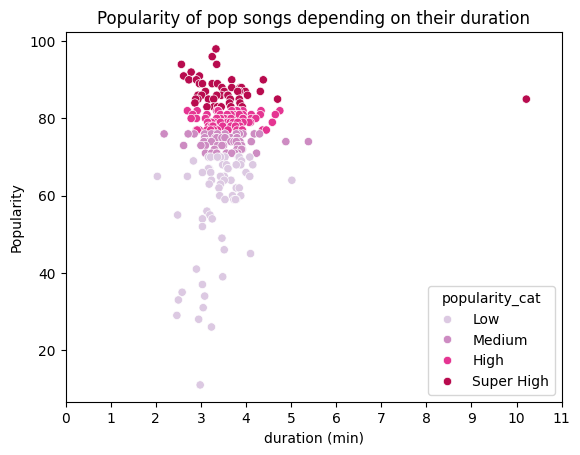

In [18]:
sns.scatterplot(data=pop_df, x="duration", y="popularity", hue="popularity_cat", palette="PuRd")
# Convert x axis ticks from seconds to minutes
ax = plt.gca()
ax.set_xticks(range(0, max(df['duration']) + 1, 60))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x / 60)}"))

# Add title and axis names
plt.title("Popularity of pop songs depending on their duration")
plt.xlabel("duration (min)")
plt.ylabel("Popularity")

plt.show()

💡 It looks like the duration to be prioritized in order to make a popular pop song is around **3 minutes**. Let's take a look at the density of the most popular songs for slices of duration now.

👉 In this case, it would be pertinent to create a "popular_df" that contains our most popular songs.

In [19]:
# Create a smaller DataFrame composed of the most popular songs
popular_df = pop_df[pop_df["popularity_cat"] == "Super High"]
popular_df.reset_index(inplace=True, drop=True)
popular_df.head(3)

,title,artist,bpm,duration,popularity,popularity_cat
0,Flowers,Miley Cyrus,118,200,98,Super High
1,BESO,ROSALÍA,95,195,96,Super High
2,Anti-Hero,Taylor Swift,97,201,94,Super High


In [14]:
popular_df.shape

(53, 6)

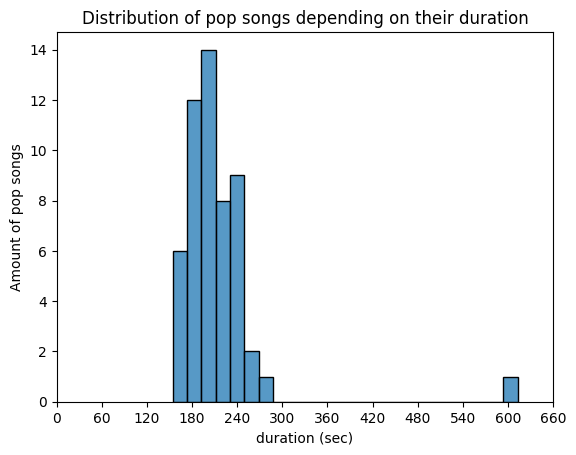

In [20]:
sns.histplot(data=popular_df, x="duration", bins=24)

# Set ticks of 60 seconds on x axis
ax = plt.gca()
ax.set_xticks(range(0, max(df['duration']) + 1, 60))

# Add title and axis labels
plt.title("Distribution of pop songs depending on their duration")
plt.xlabel("duration (sec)")
plt.ylabel("Amount of pop songs")

plt.show()

✅ This graph confirms our first thought, the duration to be prioritized while making a popular pop song is a **little more than 3 minutes**.

## 🥁 2. Which tempo should be prioritized ?
---

Here we are going to compare the popularity of pop songs with their tempo in order to find a correlation between those data.

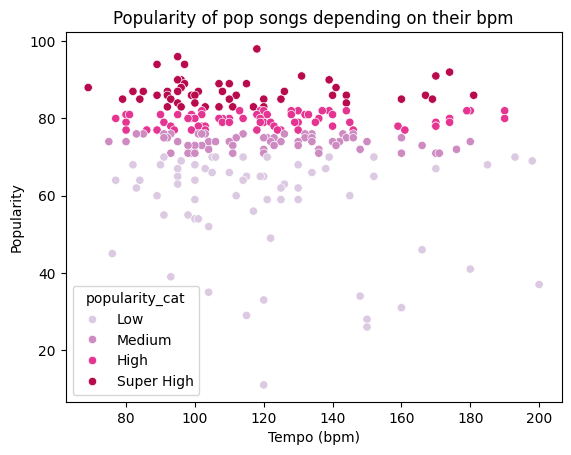

In [21]:
sns.scatterplot(data=pop_df, x="bpm", y="popularity", hue="popularity_cat", palette="PuRd")

# Add title and axis names
plt.title("Popularity of pop songs depending on their bpm")
plt.xlabel("Tempo (bpm)")
plt.ylabel("Popularity")

plt.show()

⛔ This graph is not relevant because it looks like the popular songs are scattered all around it. Still, we can observe that there is a higher **density** of dots around 100 bpm.

👉 Our next step is to draw a histogram in order to put a value on that density and identify which bpm are the popular songs composed of.

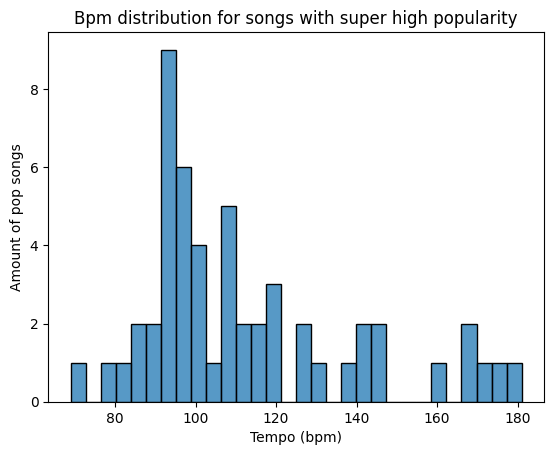

In [22]:
sns.histplot(data=popular_df, x="bpm", stat="count", bins=30)

# Add title and axis names
plt.title("Bpm distribution for songs with super high popularity")
plt.xlabel("Tempo (bpm)")
plt.ylabel("Amount of pop songs")

plt.show()

💡 It looks like the popular pop songs have a tempo between 90 and 120 bpm, even though the tempo that is the most present in popular songs is around 95 bpm.

## 3. 🗨️ Which words should be prioritized ?
---

In order to figure out which words the most popular songs are made of, we are going to need to fetch the song lyrics from the genius API using `lyricsgenius`. First, let's make a single request to check what the raw lyrics look like.


⚠️ To run this block you will need to set the `GENIUS_ACCESS_TOKEN` environment variable containing a token generated from [this page](https://genius.com/api-clients). You can store it in a `.env` file, but make sure to run the first block to load the `.env` file after you set the variable in it.

In [ ]:
# Run this block to check if the GENIUS_ACCESS_TOKEN enrvironment variable is set
os.environ.get("GENIUS_ACCESS_TOKEN")

In [275]:
from lyricsgenius import Genius
from lyricsgenius.song import Song

# Instanciate the genius client once
genius = Genius(os.environ["GENIUS_ACCESS_TOKEN"])


def search_song_lyrics(song: dict) -> Song | None:
    """Search for song lyrics using the Genius API

    Args:
        song (dict): An object containing "title" and "artist" keys to search for.

    Returns:
        Song | None: The found song, or None if nothing is found
    """
    try:
        return genius.search_song(song["title"], song["artist"], get_full_info=False)
    except Exception as e:
        print(e)
        print(f"Failed to fetch lyrics for {song['title']} | {song['artist']}.")
        return None

❗ We have defined a couple of utility functions to make the next blocks easier to read. Let's fetch !

In [276]:
# Search for a single song to see what our lyrics look like
song = search_song_lyrics(pop_df.iloc[4])
song.lyrics.splitlines()[:5]

Searching for "As It Was" by Harry Styles...


Done.


['212 ContributorsTranslationsTürkçeEspañolPortuguês日本語ItalianoΕλληνικάDeutschFrançaisTagalog / ᜆᜄᜎᜓᜄ᜔EnglishNederlandsShqipPolskiРусскийहिन्दीČesky한국어As It Was Lyrics[Intro]',
 'Come on, Harry, we wanna say goodnight to you',
 '',
 '[Verse 1]',
 "Holdin' me back"]

💡 It looks like the first line or the lyrics we get is useless for our usage, and that there are some keywords such as [Verse 1] that we will need to remove in order to get our words.

👉 Let's add some preprocessing to our song lyrics before adding them to our DataFrame.

In [277]:
def remove_lines_by_keyword(lines: list[str], keywords: list[str]) -> list[str]:
    """Remove the lines that contain any of the given keywords

    Args:
        lyrics (str): The lyrics lines in a single string
        keywords (list[str]): The list of keywords to search for

    Returns:
        str: The filtered lyrics string
    """
    indexes = []

    # Loop over the lines, find the ones that match any of the keywords and store indexes.
    for i in range(len(lines)):
        mask = [i if k in lines[i] else None for k in keywords]

        if len(list(filter(lambda item: item is not None, mask))) > 0:
            indexes.append(i)

    return [v for i, v in enumerate(lines) if i not in indexes]


def remove_punctuation(lines: list[str]) -> list[str]:
    """Remove the punctuation from the given lines

    Args:
        lines (list[str]): The lines to clean

    Returns:
        list[str]: The cleaned lines
    """
    trans = str.maketrans('', '', string.punctuation)
    return [s.translate(trans) for s in lines]


def preprocess_lyrics(lyrics: str) -> str:
    """Preprocessing to run on the Genius lyrics before adding them to the DataFrame.
    This function removes predefined keywords, punctuation and the first line and last
    word that are unfortunately corrupted.

    Args:
        lyrics (str): Song lyrics returned by the Genius api

    Returns:
        str: The preprocessed lyrics, ready to be added to a DataFrame
    """
    lines = lyrics.splitlines()[1:]
    lines = remove_lines_by_keyword(lines, ["Verse", "Chorus", "Bridge"])
    lines = remove_punctuation(lines)
    result = " ".join(lines).replace("  ", " ")
    return " ".join(result.split(" ")[:-1])

Let's run preprocessing on our song to see what our lyrics look like.

In [278]:
clean_lyrics = preprocess_lyrics(song.lyrics)
clean_lyrics

'Come on Harry we wanna say goodnight to you Holdin me back Gravitys holdin me back I want you to hold out the palm of your hand Why dont we leave it at that Nothin to say When everything gets in the way Seems you cannot be replaced And Im the one who will stay ohohoh In this world its just us You know its not the same as it was In this world its just us You know its not the same as it was As it was as it was You know its not the same Answer the phone Harry youre no good alone Why are you sitting at home on the floor What kind of pills are you on Ringin the bell And nobodys coming to help Your daddy lives by himself He just wants to know that youre well ohohoh In this world its just us You know its not the same as it was In this world its just us You know its not the same as it was As it was as it was You know its not the same Go home get ahead lightspeed internet I dont wanna talk about the way that it was Leave America two kids follow her I dont wanna talk about whos doin it first Ou

➰ Our next step consists in looping over these two utility functions to store all the song lyrics that we need for our study. This block can take a long time to execute depending on how much songs are in the DataFrame.\
We are going to only get the `Super High` popularity song lyrics as our goal is to find what lyrics these ones use.

In [279]:
lyrics = []

for index, row in popular_df.iterrows():
    song = search_song_lyrics(row)
    lyrics.append(preprocess_lyrics(song.lyrics) if song else None)

popular_df.insert(len(popular_df.columns), "lyrics", lyrics)

Searching for "Flowers" by Miley Cyrus...
Done.
Searching for "BESO" by ROSALÍA...
Done.
Searching for "Anti-Hero" by Taylor Swift...
Done.
Searching for "Kill Bill" by SZA...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Cruel Summer" by Taylor Swift...
Done.
Searching for "Unholy (feat. Kim Petras)" by Sam Smith...
Done.
Searching for "All Of The Girls You Loved Before" by Taylor Swift...
Done.
Searching for "Nonsense" by Sabrina Carpenter...
Done.
Searching for "Perfect" by Ed Sheeran...
Request timed out:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=5)
Failed to fetch lyrics for Perfect | Ed Sheeran.
Searching for "Watermelon Sugar" by Harry Styles...
Done.
Searching for "Eyes Closed" by Ed Sheeran...
Done.
Searching for "Late Night Talking" by Harry Styles...
Done.
Searching for "Lavender Haze" by Taylor Swift...
Done.
Searching for "Someone You Loved" by Lewis Capaldi...
Done.
Searching for "Blank Space" by Taylor Swift

🔎 Let's take a look at our DataFrame now that we have fetched and preprocessed the lyrics of the most popular pop songs.

In [280]:
popular_df.head(3)[["title", "artist", "lyrics"]]

,title,artist,lyrics
0,Flowers,Miley Cyrus,We were good we were gold Kinda dream that can...
1,BESO,ROSALÍA,Coro ROSALÍA Ya yo necesito otro beso Uno de ...
2,Anti-Hero,Taylor Swift,I have this thing where I get older but just n...


In [281]:
null_lyrics = popular_df["lyrics"].isnull()
print("We were not able to find the lyrics of %.2f%% of our songs." % (null_lyrics.mean() * 100))

We were not able to find the lyrics of 9.43% of our songs.


✅ This looks like a reasonable amount of data for us to delete and continue our study without.

👉 Now we should use the lyrics we managed to get and make a wordcloud to figure out which words are the most used among the most popular songs.

⚠️ For this, we will define as stopwords all the words that are 2-characters long or less, so they don't appear in our wordcloud as they would be too numerous.

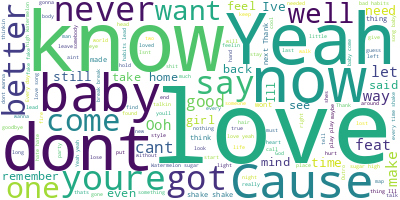

In [282]:
# Get the lyrics that are not null
lyrics = popular_df.loc[popular_df["lyrics"].notnull(), "lyrics"]

# Add the 2-character or less words to the stopwords
stopwords = [*STOPWORDS, *list(filter(lambda x: len(x) <= 2, " ".join(lyrics.values).split(" ")))]

# Generate the wordcloud
wc = WordCloud(stopwords=stopwords)
wc.generate_from_text(text=" ".join(lyrics.values))
wc.background_color = "white"
wc.to_image()

💡 What we can conclude from this is that most of the popular songs lyrics are about love. This means that lyrics about **love** should be prioritized while making a popular pop song.

## 📚 Anexes
---

- You can find the whole notebook on the [GitHub Repository](https://github.com/Lucas-COX/datamining-evaluation/blob/master/notebooks/spotify.ipynb)
- There is also a [pdf version](https://github.com/Lucas-COX/datamining-evaluation/blob/master/spotify.pdf) and [this slides version](https://github.com/Lucas-COX/datamining-evaluation/blob/master/spotify.slides.html).